In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from khmernltk import word_tokenize

from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [4]:
random.seed(42)

In [5]:
train_df = pd.read_csv('../data/processed/train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../data/processed/val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../data/processed/test_tokenized.csv', encoding='utf-8-sig')

In [6]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5427 samples)
  - val_tokenized.csv (677 samples)
  - test_tokenized.csv (678 samples)


In [7]:
label_cols = ['culture', 'economic', 'education', 'environment', 
                 'health', 'politics', 'right', 'science']

X_train_text = train_df['text_tokenized']
y_train = train_df[label_cols]

X_val_text = val_df['text_tokenized']
y_val = val_df[label_cols]

X_test_text = test_df['text_tokenized']
y_test = test_df[label_cols]

# **TF-IDF Vectorization (Raw)**

In [ ]:
tfidf = TfidfVectorizer(
    max_features=None,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2),
    analyzer=str.split        # Use str.split as text is pre-tokenized
)

X_train_tfidf = tfidf.fit_transform(train_df['text_tokenized'])
X_val_tfidf   = tfidf.transform(val_df['text_tokenized'])
X_test_tfidf  = tfidf.transform(test_df['text_tokenized'])

print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"TF-IDF shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF shape (val): {X_val_tfidf.shape}")
print(f"TF-IDF shape (test): {X_test_tfidf.shape}")

d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:542: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Vocabulary size: 16,175
TF-IDF shape (train): (5427, 16175)
TF-IDF shape (val): (677, 16175)
TF-IDF shape (test): (678, 16175)


In [9]:
feature_names = np.array(tfidf.get_feature_names_out())
label_columns = ['culture', 'economic', 'education', 'environment',
                 'health', 'politics', 'right', 'science']

top_n = 10

print("="*80)
print("TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY")
print("="*80)

for label in label_columns:
    pos_mask = (y_train.iloc[:, label_columns.index(label)] == 1).values
    pos_count = pos_mask.sum()

    if pos_count == 0:
        print(f"\n{label.upper():<12} : No positive samples")
        continue

    avg_tfidf = np.asarray(X_train_tfidf[pos_mask].mean(axis=0)).ravel()

    top_idx = avg_tfidf.argsort()[-top_n:][::-1]

    print(f"\n{label.upper():<12} (n = {pos_count} articles)")
    print("-" * 50)
    for i, idx in enumerate(top_idx):
        term = feature_names[idx]
        score = avg_tfidf[idx]
        print(f"{i+1:2}. {term:<20} {score:.4f}")

TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY

CULTURE      (n = 705 articles)
--------------------------------------------------
 1. ខ្មែរ                0.0602
 2. កម្ពុជា              0.0452
 3. បុណ្យ                0.0421
 4. ឆ្នាំ                0.0408
 5. ពិធី                 0.0380
 6. ខ្ញុំ                0.0363
 7. យើង                  0.0361
 8. សិល្បៈ               0.0359
 9. ប្រទេស               0.0323
10. វប្បធម៌              0.0323

ECONOMIC     (n = 705 articles)
--------------------------------------------------
 1. ចិន                  0.0821
 2. ប្រទេស               0.0741
 3. ពាណិជ្ជកម្ម          0.0592
 4. អាមេរិក              0.0549
 5. កម្ពុជា              0.0543
 6. សេដ្ឋកិច្ច           0.0481
 7. ពន្ធ                 0.0474
 8. អឺរ៉ុប               0.0468
 9. សហរដ្ឋ               0.0407
10. មិន                  0.0395

EDUCATION    (n = 700 articles)
--------------------------------------------------
 1. កម្ពុជា              0.0596
 2. សិស្ស                0.0

In [10]:
# Use original count / TF-IDF features
X_train_feat = X_train_tfidf
X_val_feat   = X_val_tfidf
X_test_feat  = X_test_tfidf

print(f"Train shape: {X_train_feat.shape}")
print(f"Val shape:   {X_val_feat.shape}")
print(f"Test shape:  {X_test_feat.shape}")


Train shape: (5427, 16175)
Val shape:   (677, 16175)
Test shape:  (678, 16175)


# **Train Classifiers with Class Imbalance Handling**

In [11]:
classifiers = {
    "Logistic Regression": OneVsRestClassifier(
        LogisticRegression(
            C=1.0,               # Moderate regularization; try 0.1 if overfitting
            class_weight='balanced', 
            solver='liblinear',  # Usually better for high-dimensional sparse data
            max_iter=1000, 
            random_state=42
        )
    ),
    "Linear SVM": OneVsRestClassifier(
        LinearSVC(
            C=0.1,               # Lower C = stronger regularization (prevents overfitting)
            class_weight='balanced', 
            dual=False,          # Set to False when n_samples > n_features
            random_state=42
        )
    ),
    "Random Forest": OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=500,    # More trees = more stability
            max_depth=30,        # Limit depth to prevent "memorizing" specific articles
            min_samples_leaf=2,  # Prevents creating nodes for just 1 outlier sample
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    ),
    "XGBoost": OneVsRestClassifier(
        XGBClassifier(
            n_estimators=1000,
            learning_rate=0.05,  # Slow and steady learning is better for text
            max_depth=6,         # Standard for text; prevents deep tree overfitting
            subsample=0.8,       # Only use 80% of data for each tree (adds robustness)
            colsample_bytree=0.8,# Only use 80% of features for each tree
            scale_pos_weight=5,  # Keep this since your categories are likely sparse
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
    ),
    "LightGBM": OneVsRestClassifier(
        LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,       # Standard leaf-wise growth limit
            feature_fraction=0.8, # Similar to colsample_bytree in XGB
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            importance_type='gain'
        )
    )
}

In [12]:
results = {}

print("Training and evaluating models...\n")
for name, clf in classifiers.items():
    print(f"→ Training {name}...")

    # Train on original features (Count / TF-IDF)
    clf.fit(X_train_feat, y_train)

    # Validate
    y_pred = clf.predict(X_val_feat)

    macro_f1 = f1_score(
        y_val,
        y_pred,
        average='macro',
        zero_division=0
    )

    results[name] = macro_f1

    print(f"{name} — Validation Macro F1: {macro_f1:.4f}")
    print(
        classification_report(
            y_val,
            y_pred,
            target_names=label_cols,
            zero_division=0
        )
    )
    print("-" * 60)


Training and evaluating models...

→ Training Logistic Regression...
Logistic Regression — Validation Macro F1: 0.7603
              precision    recall  f1-score   support

     culture       0.66      0.86      0.75        88
    economic       0.63      0.79      0.70        87
   education       0.67      0.91      0.77        88
 environment       0.82      0.89      0.86        93
      health       0.75      0.92      0.83        87
    politics       0.61      0.89      0.72        87
       right       0.59      0.84      0.69        93
     science       0.66      0.91      0.77        54

   micro avg       0.67      0.87      0.76       677
   macro avg       0.67      0.88      0.76       677
weighted avg       0.68      0.87      0.76       677
 samples avg       0.73      0.87      0.77       677

------------------------------------------------------------
→ Training Linear SVM...
Linear SVM — Validation Macro F1: 0.7556
              precision    recall  f1-score   sup

d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
LightGBM

d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Plotting

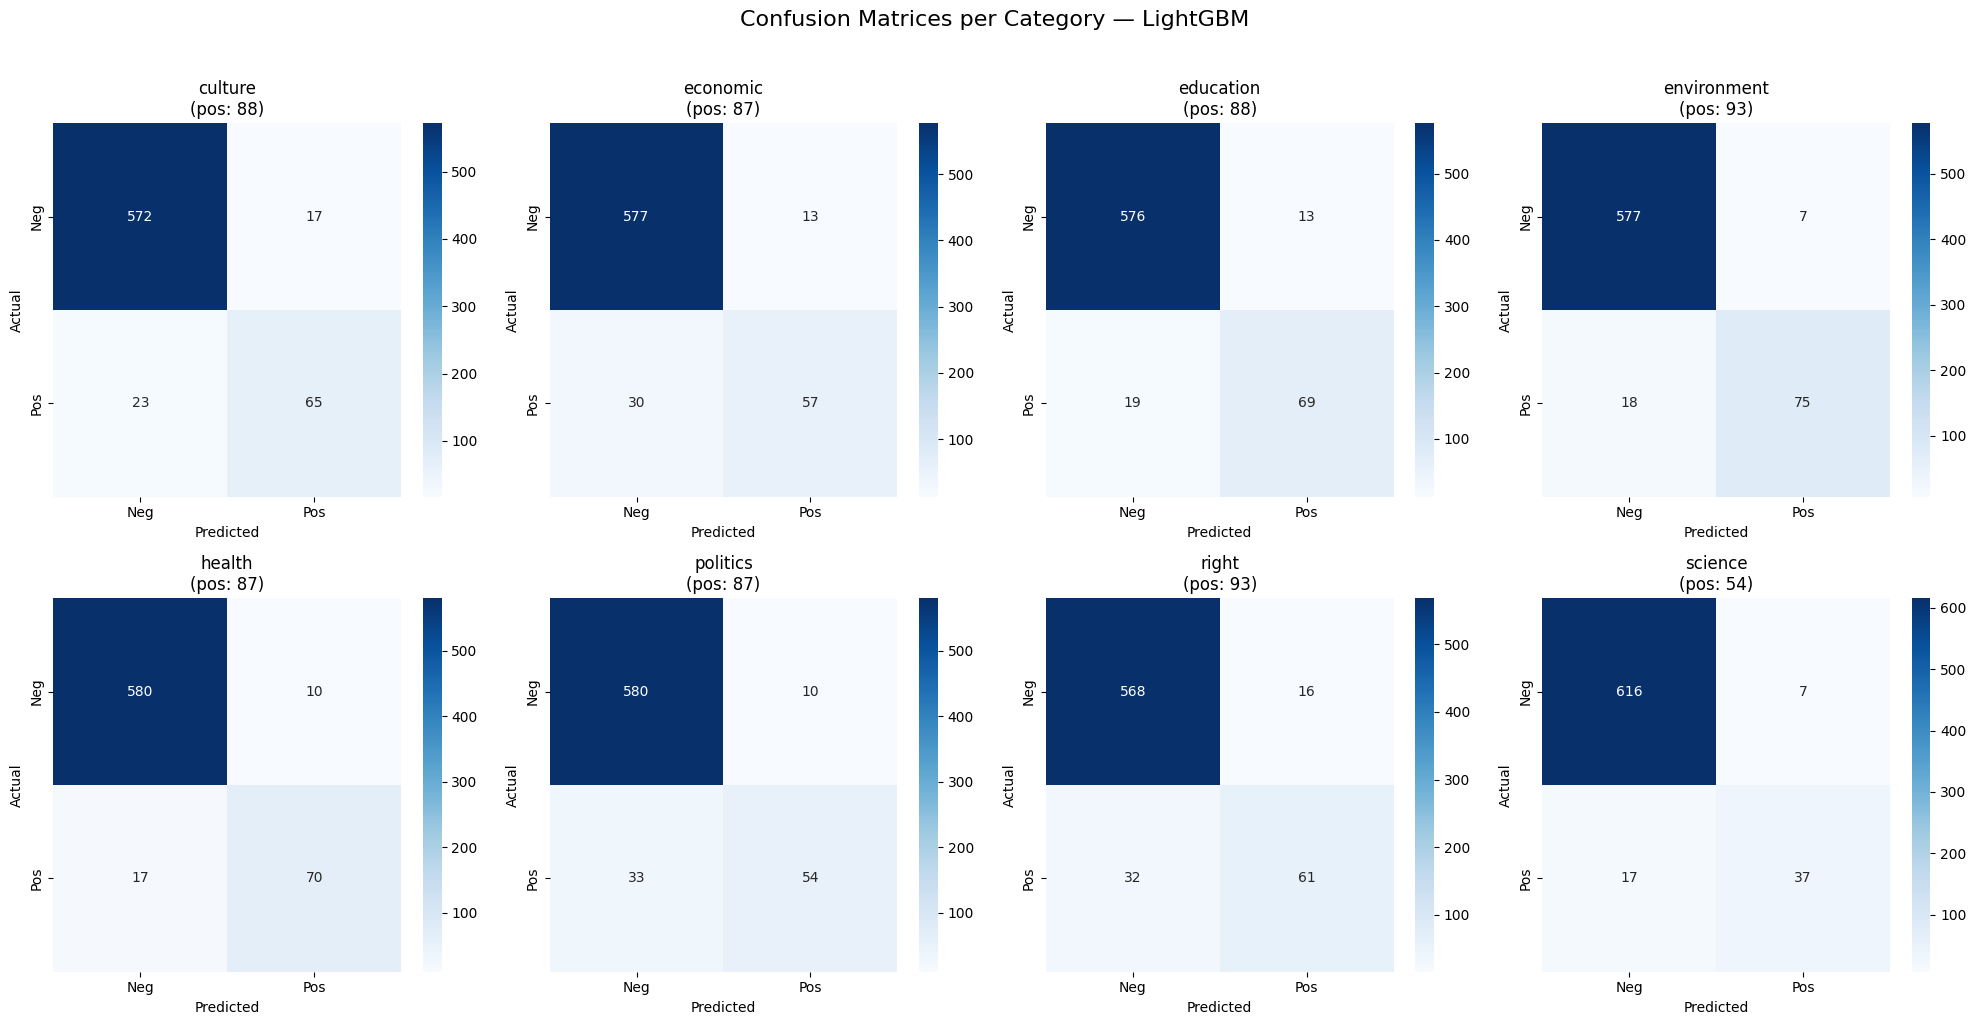

In [18]:
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]

# Predict using original features (NOT PCA)
y_pred_best = best_clf.predict(X_val_feat)

print(f"Plotting confusion matrices using: {best_model_name}")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    # Multi-label: column-wise confusion matrix
    cm = confusion_matrix(
        y_val.iloc[:, i],
        y_pred_best[:, i]
    )

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[i],
        xticklabels=['Neg', 'Pos'],
        yticklabels=['Neg', 'Pos']
    )

    axes[i].set_title(f"{label}\n(pos: {y_val.iloc[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(
    f"Confusion Matrices per Category — {best_model_name}",
    fontsize=16,
    y=1.02
)
plt.tight_layout()
plt.show()


In [17]:
print("\n" + "="*80)
print(f"STEP 1: TEST SET EVALUATION - {best_model_name}")
print("="*80)

# Predict on TEST set (NO PCA)
y_pred_test = best_clf.predict(X_test_feat)

test_macro_f1 = f1_score(
    y_test,
    y_pred_test,
    average='macro',
    zero_division=0
)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print("\n" + classification_report(
    y_test,
    y_pred_test,
    target_names=label_cols,
    zero_division=0
))



STEP 1: TEST SET EVALUATION - LightGBM
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

Test Macro F1: 0.7598

              precision    recall  f1-score   support

     culture       0.82      0.78      0.80        89
    economic       0.85      0.64      0.73        86
   education       0.82      0.74      0.78        89
 environment       0.91      0.89      0.90        94
      health       0.86      0.82      0.84        88
    politics       0.72      0.57      0.64        87
       right       0.74      0.61      0.67        92
     science       0.83      0.64      0.72    


Test Set Confusion Matrices per Category


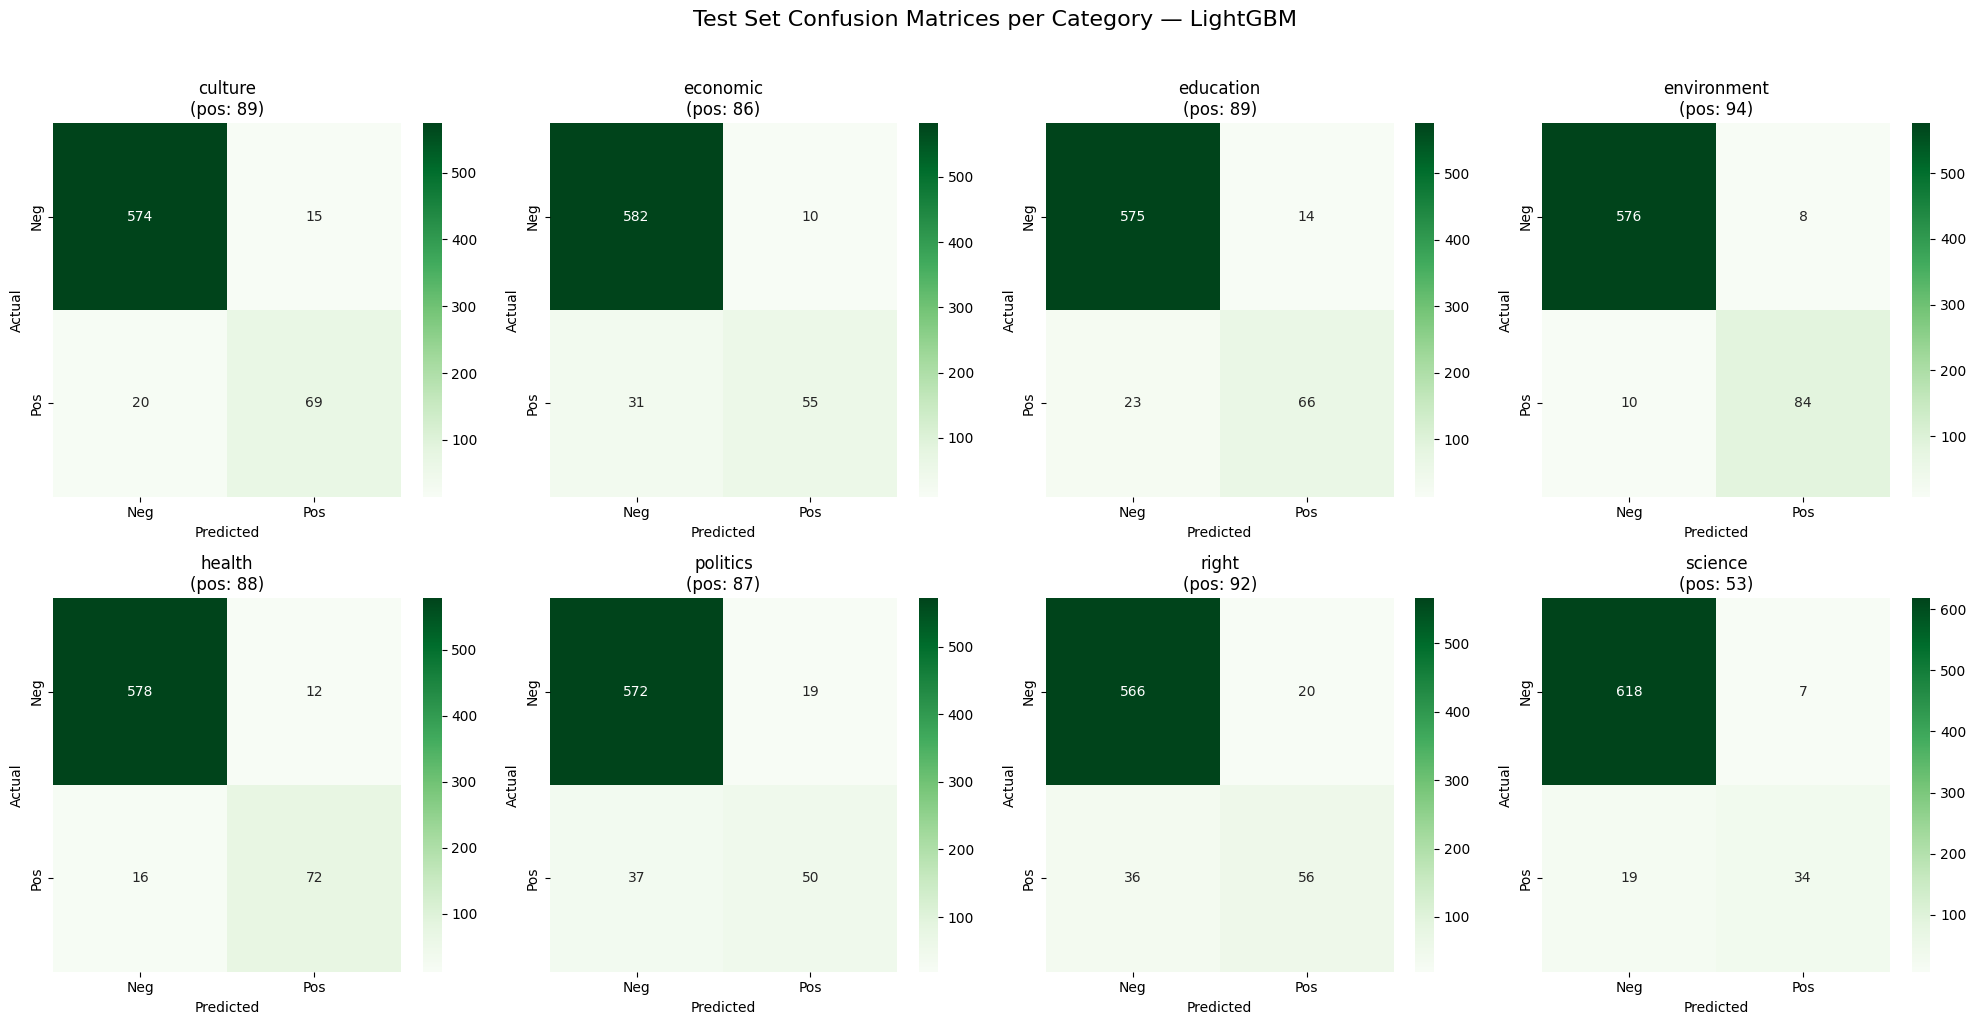

In [19]:
print("\n" + "="*80)
print("Test Set Confusion Matrices per Category")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(
        y_test.iloc[:, i],
        y_pred_test[:, i]
    )

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        ax=axes[i],
        xticklabels=['Neg', 'Pos'],
        yticklabels=['Neg', 'Pos']
    )

    axes[i].set_title(f"{label}\n(pos: {y_test.iloc[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(
    f"Test Set Confusion Matrices per Category — {best_model_name}",
    fontsize=16,
    y=1.02
)
plt.tight_layout()
plt.show()



STEP 2: COMPARING METRICS ACROSS TRAIN, VAL, TEST SETS
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

Performance Summary Across All Splits:
   Dataset  Macro F1  Samples
  Training  0.997373     5427
Validation  0.773254      677
  

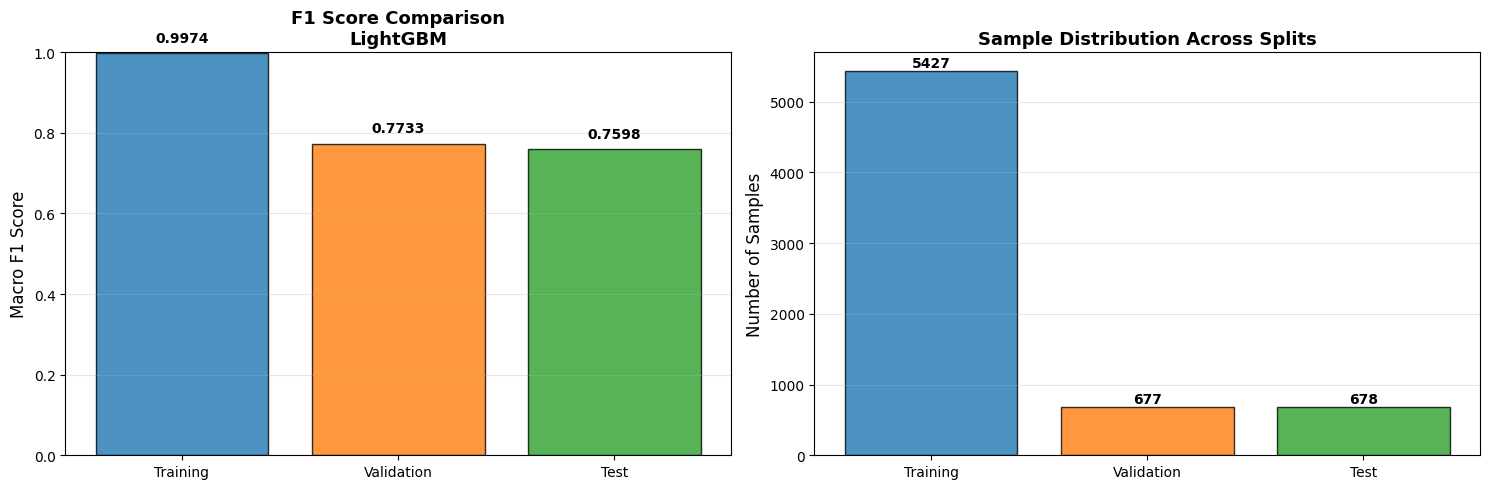


--------------------------------------------------------------------------------
Overfitting Analysis:
--------------------------------------------------------------------------------
Train → Val F1 drop: 22.47%
Train → Test F1 drop: 23.82%
⚠ Potential overfitting: Significant gap between training and test performance


In [20]:
# Step 2: Compare metrics across TRAIN, VAL, and TEST sets
print("\n" + "="*80)
print("STEP 2: COMPARING METRICS ACROSS TRAIN, VAL, TEST SETS")
print("="*80)

# Get predictions for all sets using original features
y_pred_train = best_clf.predict(X_train_feat)

# Calculate F1 scores
train_macro_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
val_macro_f1 = f1_score(y_val, y_pred_best, average='macro', zero_division=0)  # Already computed
# test_macro_f1 already computed above

# Create comparison table
comparison_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Macro F1': [train_macro_f1, val_macro_f1, test_macro_f1],
    'Samples': [len(y_train), len(y_val), len(y_test)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Summary Across All Splits:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: F1 Score Comparison
axes[0].bar(
    comparison_df['Dataset'], 
    comparison_df['Macro F1'], 
    color=['#1f77b4', '#ff7f0e', '#2ca02c'], 
    alpha=0.8, edgecolor='black'
)
axes[0].set_ylabel('Macro F1 Score', fontsize=12)
axes[0].set_title(f'F1 Score Comparison\n{best_model_name}', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Annotate bars
for i, f1 in enumerate(comparison_df['Macro F1']):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Sample Distribution
axes[1].bar(
    comparison_df['Dataset'], 
    comparison_df['Samples'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black'
)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Sample Distribution Across Splits', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Annotate bars
for i, count in enumerate(comparison_df['Samples']):
    axes[1].text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detect overfitting
print("\n" + "-"*80)
print("Overfitting Analysis:")
print("-"*80)

f1_drop_val = (train_macro_f1 - val_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0
f1_drop_test = (train_macro_f1 - test_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0

print(f"Train → Val F1 drop: {f1_drop_val:.2f}%")
print(f"Train → Test F1 drop: {f1_drop_test:.2f}%")

if f1_drop_test < 5:
    print("✓ Excellent generalization: Test performance is close to training")
elif f1_drop_test < 15:
    print("✓ Good generalization: Reasonable gap between training and test")
else:
    print("⚠ Potential overfitting: Significant gap between training and test performance")


# **Saving and Loading Each Model**

In [21]:
# Save each classifier (including the OneVsRest wrapper)
dump(classifiers["Logistic Regression"], '../models/tfidf_models_without_truncatedSVD/logistic_regression_model.joblib')
dump(classifiers["Linear SVM"], '../models/tfidf_models_without_truncatedSVD/linear_svm_model.joblib')
dump(classifiers["Random Forest"], '../models/tfidf_models_without_truncatedSVD/random_forest_model.joblib')
dump(classifiers["XGBoost"], '../models/tfidf_models_without_truncatedSVD/xgboost_model.joblib')
dump(classifiers["LightGBM"], '../models/tfidf_models_without_truncatedSVD/lightgbm_model.joblib')

print("Models and preprocessors saved successfully!")

Models and preprocessors saved successfully!


In [22]:
# Load everything
tfidf_loaded = load('../models/tfidf_models_with_truncatedSVD/tfidf_vectorizer.joblib')
ligthtgbm_loaded = load('../models/tfidf_models_without_truncatedSVD/lightgbm_model.joblib')

In [23]:
# Preprocess new text exactly like training
new_texts = ["រាជធានីភ្នំពេញ​៖ OCIC គឺជា​សម្ព័ន្ធ​សហគ្រាស និង​ជា​ក្រុមហ៊ុន​អភិវឌ្ឍន៍​អចលនទ្រព្យ​ ឈានមុខ​នៅ​ប្រទេស​កម្ពុជា និង ezesoft ផ្គត់ផ្គង់ និង​ដោះស្រាយ​សេវា​ឌី​ជី​ថ​ល​នៅ​កម្ពុជា ដែល​ជា​ផ្នែក​មួយ​នៃ​រចនាសម្ព័ន្ធ ឌី​ជី​ថ​ល ទំនាក់ទំនង និង​បច្ចេកវិទ្យា (DCT) របស់​ក្រុមហ៊ុន រ៉ូ​យ៉ា​ល់ គ្រុប បាន​ប្រកាស​ពី​ដៃគូ​យុទ្ធសាស្ត្រ ដើម្បី​ដាក់​ឱ្យ​ប្រើប្រាស់ WiFiX ដែល​ជា​សេវា WiFi សាធារណៈ​នៅ​ទីក្រុង​ន​រា ដោយ​ផ្ដល់​ជូន​ការ​ប្រើប្រាស់​អ៊ីនធឺណិត​ ដោយ​ឥត​គិតថ្លៃ មាន​សុវត្ថិភាព និង​ដំណើរការ​ពេញ 24 ម៉ោង ​។ កិច្ចព្រមព្រៀង​នេះ​ត្រូវ​បាន​ចុះហត្ថលេខា​ ដោយ​លោក Luis Chen អនុប្រធាន​ប្រតិបត្តិ​នៃ​ក្រុមហ៊ុន OCIC និង​លោក Yap Kok Leong អគ្គនាយក​ប្រតិបត្តិ​រចនាសម្ព័ន្ធ DCT របស់​ក្រុមហ៊ុន រ៉ូ​យ៉ា​ល់ គ្រុប និង​ក្រុមហ៊ុន ezesoft​ ។",
             "យោង​តាម​ការ​ផ្សាយ​របស់​មន្ទីរពេទ្យ​កាល់​ម៉ែ​ត បាន​លើក​ឡើង​ពី​ភាព​ចាំបាច់​ក្នុង​ការ​ស្វែង​យល់​អំពី​រោគ​សញ្ញា​នៃ ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ ដែល​ជា​ជំងឺ​មួយ​អាច​បង្ក​គ្រោះថ្នាក់​ធ្ងន់ធ្ងរ​ដល់​អាយុជីវិត ប្រសិនបើ​មិន​បាន​ទទួល​ការ​ព្យាបាល​ទាន់​ពេលវេលា​។ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ គឺជា​ការ​រលាក​ភ្លាម​ៗ​នៃ​ក្រពេញ​លំពែង ដែល​បង្ក​ឱ្យ​មានការ​ឈឺចាប់​ខ្លាំង​។ ដូច្នេះ ប្រសិនបើ​មាន​រោគ​សញ្ញា​ណាមួយ​ខាងក្រោម​នេះ សូម​ប្រញាប់​ទៅ​ពិគ្រោះ​ជាមួយ​គ្រូពេទ្យ​ជា​បន្ទាន់​៖រោគ​សញ្ញា​ប្រុង​ប្រយ័ត្ន​នៃ​ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ​៖ឈឺ​ចុកចាប់​ក្នុង​ពោះ​ខ្លាំងក្លា​ភ្លាម​ៗ: ជា​ពិសេស​នៅ​តំបន់​ចុងដង្ហើម ហើយ​អាច​រាលដាល​ដល់​ខ្នង (​រោគ​សញ្ញា​សំខាន់​)​។ក្អួតចង្អោរ​: ជា​រឿយ​ៗ​អម​ដោយ​អាកា​រៈ​ឈឺពោះ​។ការ​ទល់ខ្យល់ និង​លាមក​: បង្ហាញ​ពី​បញ្ហា​ក្នុង​ប្រព័ន្ធ​រំលាយ​អាហារ​។គ្រុនក្តៅ (​ឡើងក​ម្តៅ​ខ្លួន​): ជា​សញ្ញា​នៃ​ការ​រលាក​ឬ​ឆ្លង​មេរោគ​ក្នុង​រាង​កាយ​។ហត់​ដង្ហក់​ពិបាក​ដកដង្ហើម​: អាច​កើតឡើង​ក្នុង​ករណី​ធ្ងន់ធ្ងរ​។ដំបូន្មាន​សំខាន់​: ការ​ឈឺចាប់​ខ្លាំង​នៅ​ពោះ​ផ្នែក​ខាងលើ គឺជា​សញ្ញា​ដាស់តឿន​ដ៏​ធំ​។ កុំ​ធ្វេសប្រហែស​! ការ​ស្វែងរក​ការ​ពិនិត្យ​និង​ព្យាបាល​ទាន់​ពេលវេលា​ពី​គ្រូពេទ្យ​ឯកទេស គឺជា​គន្លឹះ​ដើម្បី​ជួយ​សង្គ្រោះ​ជីវិត​អ្នកជំងឺ​៕"]

In [24]:
def clean_khmer_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Remove html tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # 2. Remove zero-width characters
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)

    # 3. Remove punctuation (Latin + Khmer)
    text = re.sub(r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]', '', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def khmer_tokenize(text):
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned)

    processed_tokens = []
    for token in tokens:
        # Pure English token (letters/numbers only)?
        if re.match(r'^[a-zA-Z0-9]+$', token):
            token_lower = token.lower()
            # Remove if it's an NLTK English stopword
            if token_lower in english_stopwords:
                continue
            processed_tokens.append(token_lower)  # Lowercase content English words
        else:
            # Keep Khmer or mixed tokens as-is
            processed_tokens.append(token)

    return " ".join(processed_tokens)

In [25]:
# Preprocess exactly like training
new_tokenized = [khmer_tokenize(text) for text in new_texts]

# Transform using the saved CountVectorizer / TF-IDF
X_new_tfidf_vec = tfidf_loaded.transform(new_tokenized)


# Get binary predictions
binary_predictions = ligthtgbm_loaded.predict(X_new_tfidf_vec)

# Get probabilities (shape: [n_articles, n_classes])
probabilities = ligthtgbm_loaded.predict_proba(X_new_tfidf_vec)

# Example article titles for plotting / display
article_titles = [
    "OCIC and ezesoft Partner to Launch Free Public WiFi Service in Angkor",
    "Recognizing Symptoms of Acute Appendicitis"
]


| 2026-01-13 20:45:57,985 | INFO | khmer-nltk | Loaded model from d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\khmernltk\word_tokenize\sklearn_crf_ner_10000.sav |


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

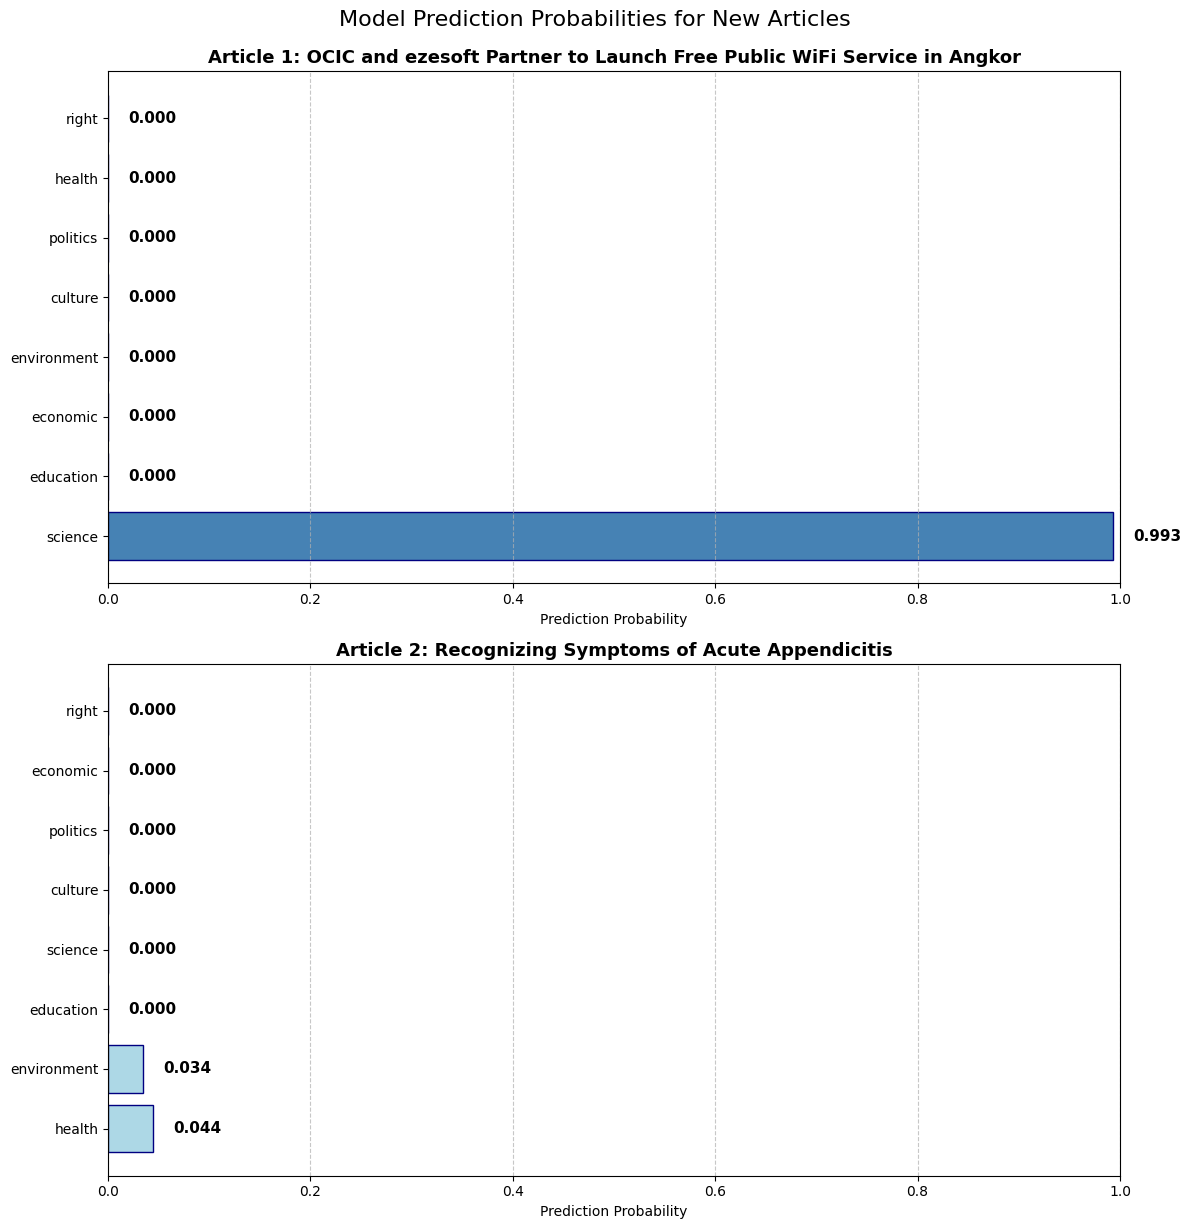

In [26]:
# Plot bar charts for new articles
fig, axes = plt.subplots(len(article_titles), 1, figsize=(12, 6 * len(article_titles)))

# Ensure axes is always iterable
if len(article_titles) == 1:
    axes = [axes]

for idx, (probs, ax, title) in enumerate(zip(probabilities, axes, article_titles)):
    # Sort categories by probability (descending)
    sorted_idx = np.argsort(probs)[::-1]
    sorted_labels = [label_cols[i] for i in sorted_idx]
    sorted_probs = probs[sorted_idx]

    # Colors: highlight high confidence (>0.5)
    colors = ['steelblue' if p > 0.5 else 'lightblue' for p in sorted_probs]

    bars = ax.barh(sorted_labels, sorted_probs, color=colors, edgecolor='navy')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Prediction Probability')
    ax.set_title(f"Article {idx+1}: {title}", fontsize=13, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Annotate values on bars
    for bar, p in zip(bars, sorted_probs):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f'{p:.3f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.suptitle("Model Prediction Probabilities for New Articles", fontsize=16, y=1.02)
plt.show()


# Comparision

In [27]:
# Paths
no_truncatedSVD_path = '../models/tfidf_models_without_truncatedSVD/'
truncatedSVD_path    = '../models/tfidf_models_with_truncatedSVD/'

# --- Load No-TruncatedSVD models ---
no_truncatedSVD_models = {
    "Logistic Regression": load(os.path.join(no_truncatedSVD_path, "logistic_regression_model.joblib")),
    "Linear SVM": load(os.path.join(no_truncatedSVD_path, "linear_svm_model.joblib")),
    "Random Forest": load(os.path.join(no_truncatedSVD_path, "random_forest_model.joblib")),
    "XGBoost": load(os.path.join(no_truncatedSVD_path, "xgboost_model.joblib")),
    "LightGBM": load(os.path.join(no_truncatedSVD_path, "lightgbm_model.joblib"))
}

# Load preprocessing objects for No-TruncatedSVD
tfidf_no_truncatedSVD = load(os.path.join(truncatedSVD_path, "tfidf_vectorizer.joblib"))
# --- Load TruncatedSVD models ---
tfidf_models = {
    "Logistic Regression": load(os.path.join(truncatedSVD_path, "logistic_regression_model.joblib")),
    "Linear SVM": load(os.path.join(truncatedSVD_path, "linear_svm_model.joblib")),
    "Random Forest": load(os.path.join(truncatedSVD_path, "random_forest_model.joblib")),
    "XGBoost": load(os.path.join(truncatedSVD_path, "xgboost_model.joblib")),
    "LightGBM": load(os.path.join(truncatedSVD_path, "lightgbm_model.joblib"))
}

# Load preprocessing objects for TruncatedSVD
tfidf_vec_truncatedSVD = load(os.path.join(truncatedSVD_path, "tfidf_vectorizer.joblib"))
truncatedSVD_loaded = load(os.path.join(truncatedSVD_path, "truncated_svd.joblib"))

print("All models and preprocessors loaded successfully!")

All models and preprocessors loaded successfully!


In [28]:
n_components = min(X_train_tfidf.shape[0]-1, X_train_tfidf.shape[1]-1, 1663)

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [29]:
# Collect F1 scores for all models
def collect_metrics(models_dict, X_test_input, y_test_df):
    results = {}
    for name, model in models_dict.items():
        y_pred = model.predict(X_test_input)
        macro_f1 = f1_score(y_test_df, y_pred, average='macro', zero_division=0)
        results[name] = {"f1": macro_f1, "y_pred": y_pred}
    return results

# No-TruncatedSVD
metrics_no_truncatedSVD = collect_metrics(no_truncatedSVD_models, X_test_feat, y_test)

# TruncatedSVD
metrics_truncatedSVD = collect_metrics(tfidf_models, X_test_svd, y_test)


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid featur

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


d:\ITC_Year_5\WR\KhmerTextClassification\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


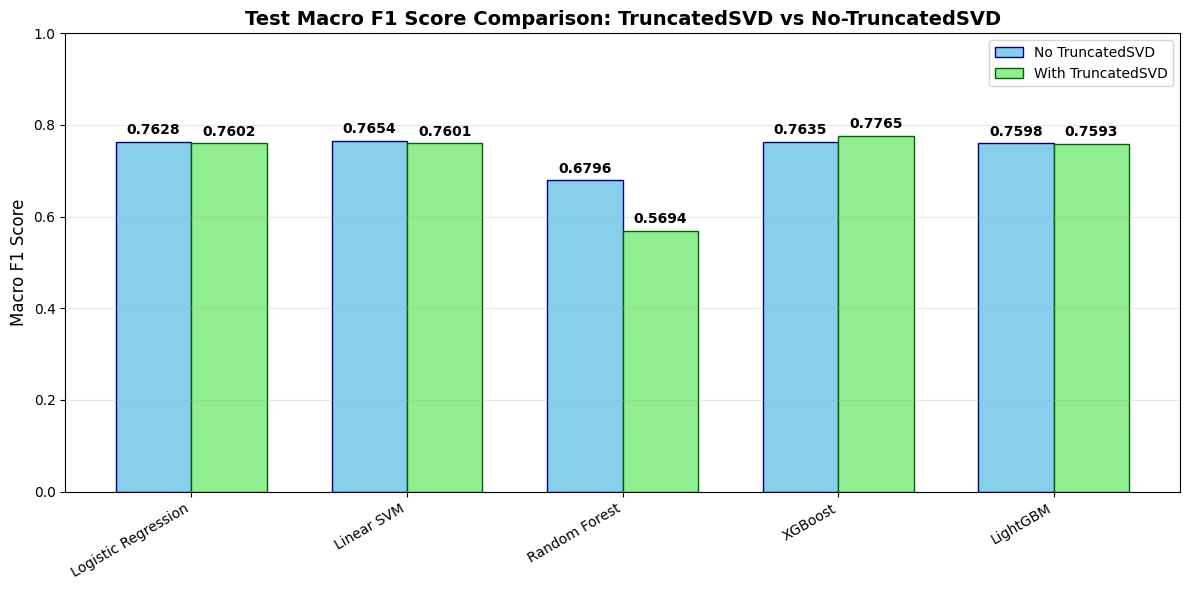

In [30]:
model_names = list(no_truncatedSVD_models.keys())
f1_no_truncatedSVD = [metrics_no_truncatedSVD[name]["f1"] for name in model_names]
f1_truncatedSVD = [metrics_truncatedSVD[name]["f1"] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, f1_no_truncatedSVD, width, label='No TruncatedSVD', color='skyblue', edgecolor='navy')
rects2 = ax.bar(x + width/2, f1_truncatedSVD, width, label='With TruncatedSVD', color='lightgreen', edgecolor='darkgreen')

ax.set_ylabel('Macro F1 Score', fontsize=12)
ax.set_title('Test Macro F1 Score Comparison: TruncatedSVD vs No-TruncatedSVD', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
ax.legend()

# Annotate bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


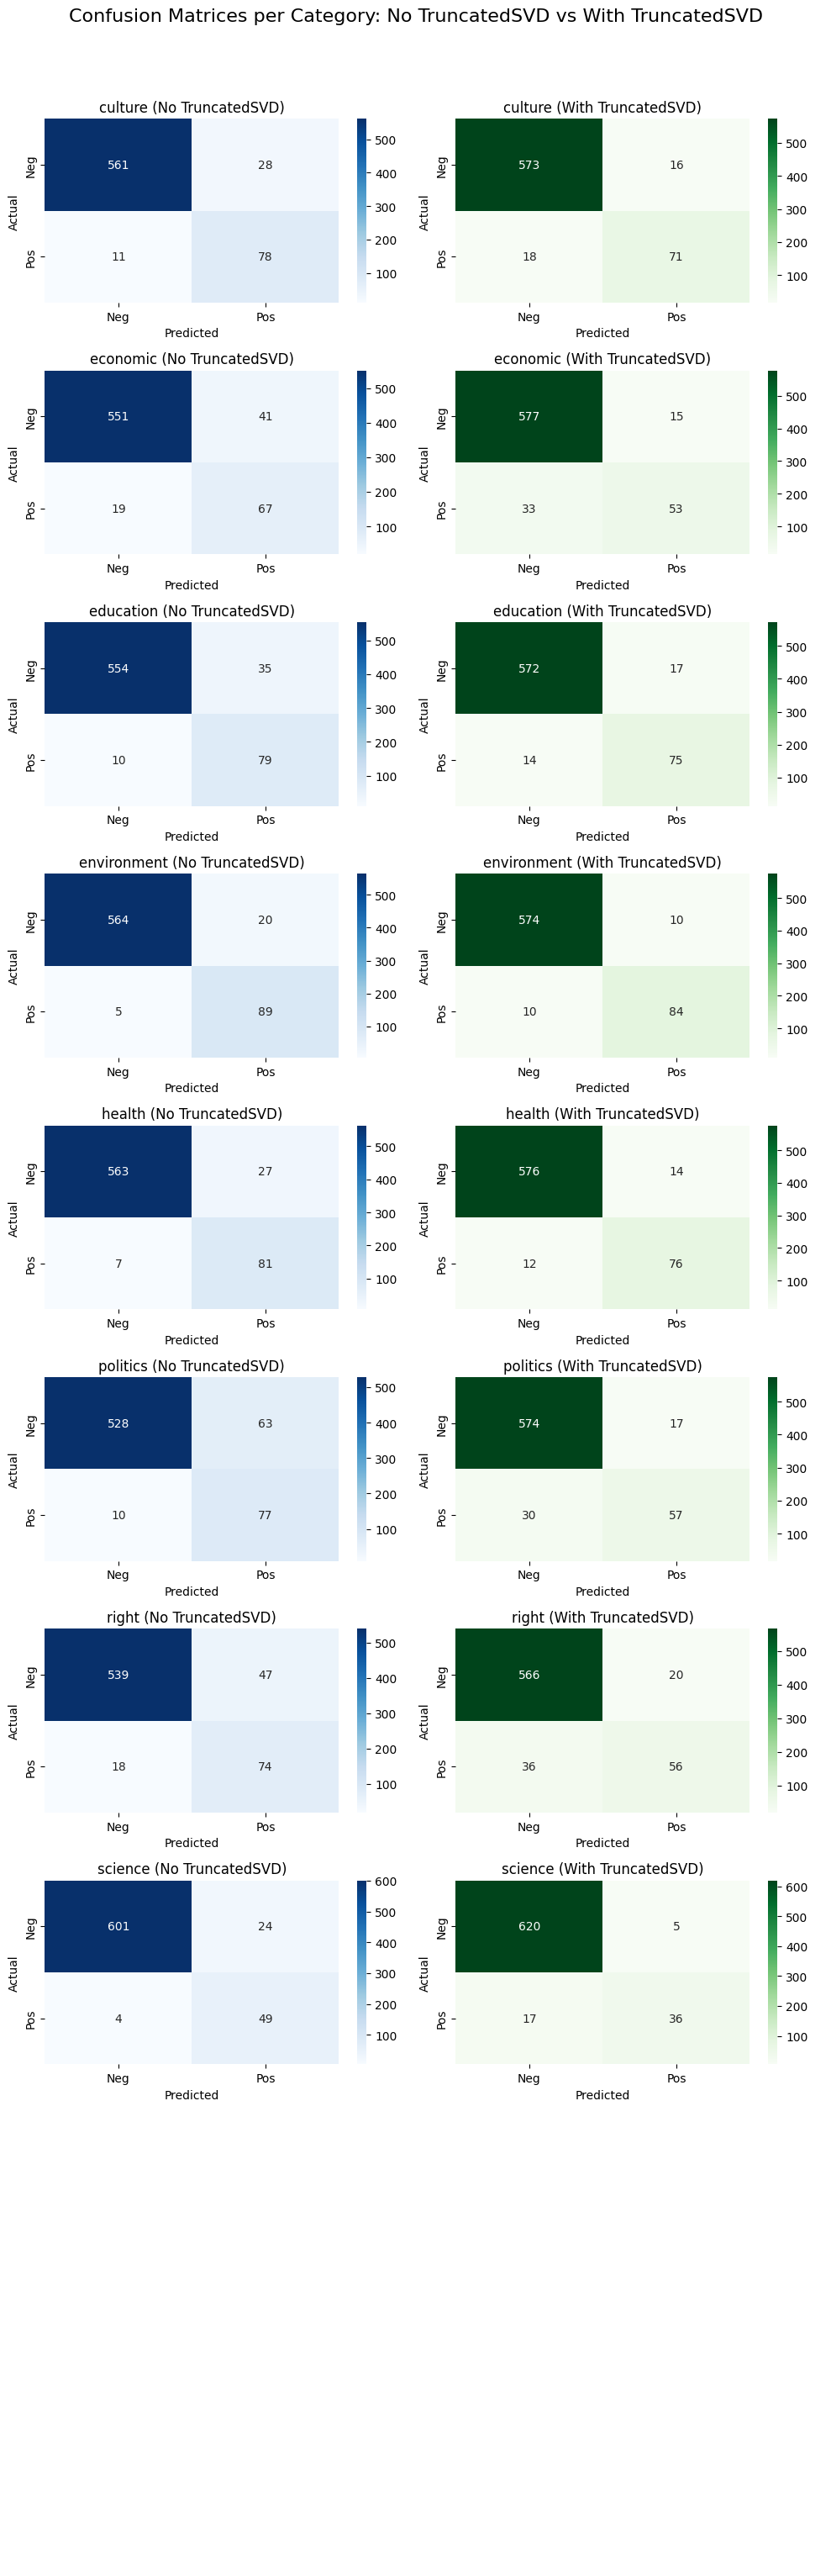

In [31]:
# Best models
best_no_truncatedSVD_name = max(metrics_no_truncatedSVD, key=lambda k: metrics_no_truncatedSVD[k]["f1"])
best_truncatedSVD_name    = max(metrics_truncatedSVD, key=lambda k: metrics_truncatedSVD[k]["f1"])

best_no_truncatedSVD_pred = metrics_no_truncatedSVD[best_no_truncatedSVD_name]["y_pred"]
best_truncatedSVD_pred    = metrics_truncatedSVD[best_truncatedSVD_name]["y_pred"]
# --- Two columns, 10 rows (or 8 rows for 8 categories)
n_rows = 10
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 3*n_rows))  # width 2 columns, height per row

for i, label in enumerate(label_cols):
    # No TruncatedSVD -> left column
    cm_no_truncatedSVD = confusion_matrix(y_test.iloc[:, i], best_no_truncatedSVD_pred[:, i])
    sns.heatmap(cm_no_truncatedSVD, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0],
                xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    axes[i, 0].set_title(f"{label} (No TruncatedSVD)")
    axes[i, 0].set_xlabel("Predicted")
    axes[i, 0].set_ylabel("Actual")

    # With TruncatedSVD -> right column
    cm_truncatedSVD = confusion_matrix(y_test.iloc[:, i], best_truncatedSVD_pred[:, i])
    sns.heatmap(cm_truncatedSVD, annot=True, fmt='d', cmap='Greens', ax=axes[i, 1],
                xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    axes[i, 1].set_title(f"{label} (With TruncatedSVD)")
    axes[i, 1].set_xlabel("Predicted")
    axes[i, 1].set_ylabel("Actual")

# Turn off extra rows if n_rows > len(label_cols)
for j in range(len(label_cols), n_rows):
    axes[j, 0].axis('off')
    axes[j, 1].axis('off')

plt.suptitle("Confusion Matrices per Category: No TruncatedSVD vs With TruncatedSVD", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
